# Check tensorflow and the avability of GPUs

In [1]:
# tensorflow_version 2
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
!pip install tensorflow

ERROR: Could not find a version that satisfies the requirement tensorflow (from versions: none)
ERROR: No matching distribution found for tensorflow


In [3]:
# Copy the weights and configurations for the pre-trained models

# Data preparation

In [4]:
dataset_directory  = "/Users/MrBS/Desktop/dr-final/diabetic-retinopathy/Images"

In [5]:
!pip install sklearn

In [6]:
from glob import glob
from sklearn.model_selection import train_test_split

In [7]:
distinct_labels = [
  '0 No_DR',
  '1 Mild',
  '2 Moderate',
  '3 Severe',
  '4 Proliferate_DR'
]

In [8]:
import os
images_directory = os.path.join(dataset_directory, 'all')

In [9]:
import os

def read_images(images_directory):
    images = []
    labels = []

    for label in os.listdir(images_directory):
        if label not in ['.DS_Store']:
            label_number = distinct_labels.index(label)
            labeled_image_path = os.path.join(images_directory, label)
            labeled_images = [os.path.join(labeled_image_path, image) for image in os.listdir(labeled_image_path)]
            images.extend(labeled_images)
            labels.extend([label_number] * len(labeled_images))
    return images, labels

In [10]:
images, labels = read_images(images_directory)

# Plot some random images from the dataset

In [11]:
!pip install Pillow
!pip install matplotlib

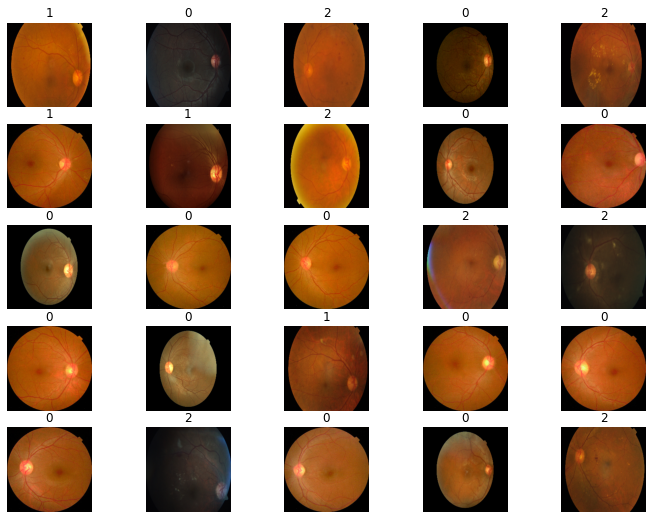

In [12]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

random_data_indices = np.random.choice(list(range(len(images))), 25)
sample_data = [images[i] for i in random_data_indices]
sample_labels = [labels[i] for i in random_data_indices]

N, R, C = 25, 5, 5
plt.figure(figsize=(12, 9))
for k, (src, label) in enumerate(zip(sample_data, sample_labels)):
    im = Image.open(src).convert('RGB')
    plt.subplot(R, C, k+1)
    plt.title(label)
    plt.imshow(np.asarray(im))
    plt.axis('off')

# Model customization

In [13]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input

In [14]:
CLASSES = len(distinct_labels)
 
    
"""trying new type"""
base_model = InceptionV3(weights='imagenet', include_top=False)
x = InceptionV3(weights='imagenet', include_top=True)

x = base_model.output
x = GlobalAveragePooling2D(name='avg_pool')(x)
# x = Dropout(0.4)(x)
predictions = Dense(CLASSES, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)
# setup model
#base_model = InceptionV3(weights='imagenet', include_top=True)

#x = base_model.output
#x = GlobalAveragePooling2D(name='avg_pool')(x)
# x = Dropout(0.4)(x)
#predictions = Dense(CLASSES, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)
   
# transfer learning
for layer in base_model.layers:
    layer.trainable = False
      
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Data augmentation

In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [16]:
WIDTH = 224
HEIGHT = 224
BATCH_SIZE = 32

TRAIN_DIR = os.path.join(dataset_directory, 'train')
TEST_DIR = os.path.join(dataset_directory, 'test')

# data prep
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

validation_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(HEIGHT, WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical')
    
validation_generator = validation_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(HEIGHT, WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical')

Found 2929 images belonging to 5 classes.
Found 733 images belonging to 5 classes.


Plot some images result of data augmentation.

In [17]:
!pip install SciPy

In [18]:
!pip install pillow

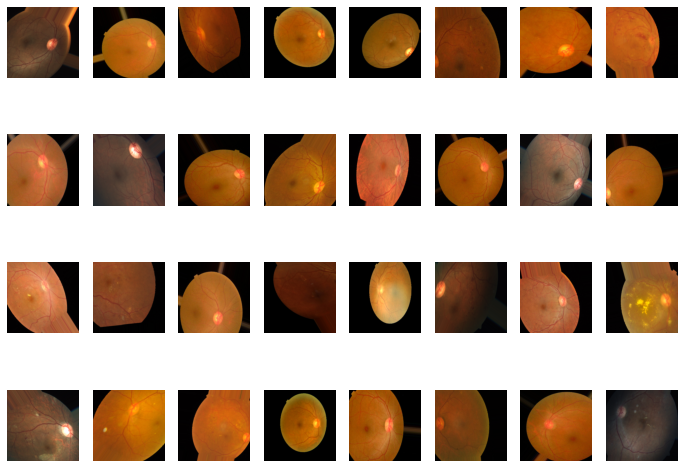

In [19]:
x_batch, y_batch = next(train_generator)

plt.figure(figsize=(12, 9))
for k, (img, lbl) in enumerate(zip(x_batch, y_batch)):
    plt.subplot(4, 8, k+1)
    plt.imshow((img + 1) / 2)
    plt.axis('off')

# Transfer learning

In [ ]:
EPOCHS = 10
BATCH_SIZE = 32
STEPS_PER_EPOCH = 90
VALIDATION_STEPS = 20

MODEL_FILE = 'dr_inception_v3.model'

history = model.fit_generator(
    train_generator,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=validation_generator,
    validation_steps=VALIDATION_STEPS)
  
model.save(MODEL_FILE)

<ipython-input-20-bcb8fc68f2c1>:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/10
90/90 [==============================] - 24s 246ms/step - loss: 1.0674 - accuracy: 0.6213 - val_loss: 0.9041 - val_accuracy: 0.6438
Epoch 2/10
90/90 [==============================] - 21s 231ms/step - loss: 0.8194 - accuracy: 0.7044 - val_loss: 0.8403 - val_accuracy: 0.6703
Epoch 3/10
90/90 [==============================] - 21s 231ms/step - loss: 0.7654 - accuracy: 0.7302 - val_loss: 0.8458 - val_accuracy: 0.6891
Epoch 4/10
90/90 [==============================] - 21s 230ms/step - loss: 0.7611 - accuracy: 0.7176 - val_loss: 0.7843 - val_accuracy: 0.7000
Epoch 5/10
90/90 [==============================] - 21s 230ms/step - loss: 0.7496 - accuracy: 0.7239 - val_loss: 0.7211 - val_accuracy: 0.7266
Epoch 6/10
90/90 [==============================] - 21s 231ms/step - loss: 0.7155 - accuracy: 0.7347 - val_loss: 0.7921 - val_accuracy: 0.7078
Epoch 7/10
90/90 [==============================] - 21s 235ms/step - loss: 0.6912 - accuracy: 0.7400 - val_loss: 0.7015 - val_accuracy: 0.7234

In [ ]:
def plot_training(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(len(acc))
  
  plt.plot(epochs, acc, 'r')
#   plt.plot(epochs, val_acc, 'r')
  plt.title('Training and validation accuracy')
  
  plt.figure()
  plt.plot(epochs, loss, 'r')
#   plt.plot(epochs, val_loss, 'r-')
  plt.title('Training and validation loss')
  plt.show()


In [ ]:
len(history.history['accuracy'])

In [ ]:
plot_training(history)

# Prediction of the custom model

### Split Data into Training and Validation

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from keras.preprocessing import image
from keras.models import load_model

def process_image(image_path):
    img = image.load_img(image_path, target_size=(HEIGHT, WIDTH))
    img_data = image.img_to_array(img)
    img_data = np.expand_dims(img_data, axis=0)
    img_data = preprocess_input(img_data)
    return img_data

def predict(model, img):
    """Run model prediction on image
    Args:
        model: keras model
        img: PIL format image
    Returns:
        list of predicted labels and their probabilities 
    """
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    preds = model.predict(x)
    return preds[0]


def plot_preds(img, preds):
    """Displays image and the top-n predicted probabilities in a bar graph
    Args:
        preds: list of predicted labels and their probabilities
    """
    label_numbers = list(range(len(distinct_labels)))
    gs = gridspec.GridSpec(2, 1, height_ratios=[4, 1])
    plt.figure(figsize=(8,8))
    plt.subplot(gs[0])
    plt.imshow(np.asarray(img))
    plt.subplot(gs[1])
    plt.barh(label_numbers, preds, alpha=0.5)
    plt.yticks(label_numbers, distinct_labels)
    plt.xlabel('Probability')
    plt.tight_layout()

In [ ]:
model = load_model(MODEL_FILE)

In [ ]:
def predict_and_plot(image_path):
    print(image_path)
    img = image.load_img(image_path, target_size=(HEIGHT, WIDTH))
    preds = predict(model, img)

    plot_preds(img, preds)
    return preds

In [ ]:
import random

def test_label_prediction(label, limit):
    test_severe_images = [os.path.join(TEST_DIR, label, image) for image in os.listdir(os.path.join(TEST_DIR, label))]
    random.shuffle(test_severe_images)
    sample = test_severe_images[:limit]
    for image in sample:
        predict_and_plot(image)

In [ ]:
# testing some Severe labeled images
test_label_prediction('0 No_DR', 5)

In [ ]:
# testing some Severe labeled images
test_label_prediction('1 Mild', 5)

In [ ]:
# testing some Severe labeled images
test_label_prediction('2 Moderate', 5)

In [ ]:
# testing some Severe labeled images
test_label_prediction('3 Severe', 5)

In [ ]:
# testing some Severe labeled images
test_label_prediction('4 Proliferate_DR', 5)

In [ ]:
# Test Performance

In [ ]:
test_images_path, test_labels = read_images(TEST_DIR)

In [ ]:
len(test_images_path)

In [ ]:
test_images = [process_image(path) for path in test_images_path]

In [ ]:
predictions = model.predict(test_images[0])[0]

In [ ]:
predictions

In [ ]:
np.where(predictions == max(predictions))[0][0]

In [ ]:
predicted_labels = []
for image in test_images:
    probabilities = model.predict(image)[0]
    predicted_label = np.where(probabilities == max(probabilities))[0][0]
    predicted_labels.append(predicted_label)

In [ ]:
import tensorflow as tf
confusion = tf.math.confusion_matrix(labels=test_labels, predictions=predicted_labels, num_classes=len(distinct_labels),cmap='Blues')

In [ ]:
confusion

In [ ]:
print(distinct_labels)

In [ ]:
correct_predictions = [np.array(confusion)[i][i] for i in range(len(distinct_labels))]

In [ ]:
list(zip(distinct_labels, correct_predictions))